## Clustering

### Gaussian Mixture Model (GMM)
(an alternative R's Mclust package - for a direct implementation in Python)

In [ ]:
experimental_mode = False

In [10]:
import os, joblib

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from IPython.display import display

In [ ]:
# BASE_DIR = Path.cwd().parent
BASE_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project'
OUTPUTS_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs'
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

Loaded scaled feature matrix with shape: (1722864, 12)


In [ ]:
# Finding optimal number of cluster for GMM - using the Bayesian Information Criterion (BIC)

# Repliating the Methodology
# The Flow Classification paper used the BIC to find the
# optimal model (k and covariance type). We will do the same.
# We will test a range of cluster counts (k) and all 4 covariance types.

if experimental_mode:
  X_scaled = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv')

  # This assumes 'X_scaled' is your scaled data from the StandardScaler step
  if 'X_scaled' not in locals():
      print("Error: 'X_scaled' variable not found.")
      print("Please ensure you have run the StandardScaler cell (cell 11) first.")
  else:
      # 1. Define your search space
      # We test k=2 through k=10
      n_components_range = range(2, 11)
      # We test all 4 available covariance types
      covariance_types = ['spherical', 'diag', 'tied', 'full']

      # 2. Iterate and find the best BIC
      lowest_bic = np.inf
      best_model = None
      best_n_components = -1
      best_covariance_type = ""

      # Store BIC scores for plotting
      bic_scores = []

      print("Starting GMM model search using BIC...")

  for cov_type in covariance_types:
      for n_components in n_components_range:
          gmm = GaussianMixture(
              n_components=n_components,
              covariance_type=cov_type,
              random_state=42,
              n_init=10,
              max_iter=200
          )
          gmm.fit(X_scaled)
          bic = gmm.bic(X_scaled)
          bic_scores.append((cov_type, n_components, bic))
          if bic < lowest_bic:
              lowest_bic = bic
              best_model = gmm
              best_n_components = n_components
              best_covariance_type = cov_type

          print("---")
          print("Search Complete. Best Model Found:")
          print(f"  Covariance Type: {best_covariance_type}")
          print(f"  Num Clusters (k): {best_n_components}")
          print(f"  Lowest BIC Score: {lowest_bic:.2f}")
          print("---")

          #  Visualization of BIC Scores
          print("Plotting BIC scores...")
          df_bic = pd.DataFrame(bic_scores, columns=['covariance_type', 'n_components', 'BIC'])

          plt.figure(figsize=(12, 8))
          sns.lineplot(
              data=df_bic,
              x='n_components',
              y='BIC',
              hue='covariance_type',
              marker='o'
          )
          plt.title('GMM Model Selection using BIC')
          plt.xlabel('Number of Clusters (k)')
          plt.ylabel('Bayesian Information Criterion (BIC)')
          plt.xticks(n_components_range)
          plt.legend(title='Covariance Type')
          plt.grid(True, linestyle='--', alpha=0.6)
          plt.axvline(best_n_components, linestyle='--', color='red', label=f'Best k ({best_n_components})')
          plt.axhline(lowest_bic, linestyle='--', color='red', label=f'Lowest BIC ({lowest_bic:.2f})')
          plt.legend()
          plt.show()

          # Ensure OUTPUTS_DIR exists and save the plot
          os.makedirs(OUTPUTS_DIR, exist_ok=True)
          bic_plot_path = os.path.join(BASE_DIR, 'gmm_bic_selection.png')
          plt.savefig(bic_plot_path)
          plt.close()
          print(f"BIC plot saved to {bic_plot_path}")

          #  Save the model and artifacts
          model_path = os.path.join(OUTPUTS_DIR, 'gmm_best_model.joblib')
          joblib.dump(best_model, model_path)
          print(f"Best GMM model saved to {model_path}")

          bic_csv_path = os.path.join(OUTPUTS_DIR, 'gmm_bic_scores.csv')
          df_bic.to_csv(bic_csv_path, index=False)
          print(f"BIC scores saved to {bic_csv_path}")

          #  Use best model for clustering
          print(f"\nUsing best model (k={best_n_components}, type='{best_covariance_type}') to predict clusters...")
          cluster_labels_gmm = best_model.predict(X_scaled)

          # Save cluster labels
          clusters_path = os.path.join(OUTPUTS_DIR, 'gmm_cluster_labels.npy')
          np.save(clusters_path, cluster_labels_gmm)
          print(f"Cluster labels saved to {clusters_path}")

          session_feature_matrix = pd.read_csv(f'{BASE_DIR}/session_feature_matrix.csv')
          if 'session_feature_matrix' in locals():
              session_feature_matrix['cluster_gmm'] = cluster_labels_gmm
              print("Added 'cluster_gmm' column to session_feature_matrix.")
              print(session_feature_matrix['cluster_gmm'].value_counts())
              # Optionally, save the updated dataframe
              df_csv_path = os.path.join(OUTPUTS_DIR, 'df_session_matrix_features_with_gmm_clusters.csv')
              session_feature_matrix.to_csv(df_csv_path, index=False)
              print(f"Updated DataFrame with cluster labels saved to {df_csv_path}")
          else:
              print("Warning: 'session_feature_matrix' not found. Could not add cluster labels.")
else:
  print("Not in experimental mode, skipping BIC calculations on full dataset")

Not in experimental mode, skipping BIC calculations on full dataset


In [12]:
# Using optimal clusters value (k=7) based on the the experiment above to cluster our sessions df

# ============================================================================
# TRAIN GMM WITH k=7 (FULL COVARIANCE)
# ============================================================================

#  Configuration
DATA_PATH = f'{BASE_DIR}/session_feature_matrix_scaled.csv'

#  Load Scaled Data
print("=" * 80)
print("RETRAINING GMM WITH k=7 (Full Covariance)")
print("=" * 80)
print(f"\nLoading scaled data from {DATA_PATH}...")
X_scaled_df = pd.read_csv(DATA_PATH, index_col='session_id')
print(f"Data loaded successfully. Shape: {X_scaled_df.shape}")

#  Train GMM with k=7, full covariance
print("\n Training GMM with k=7")
gmm_k7 = GaussianMixture(
    n_components=7,
    covariance_type='full',
    random_state=42,
    n_init=10,
    max_iter=200
)

gmm_k7.fit(X_scaled_df)
bic_k7 = gmm_k7.bic(X_scaled_df)

print(f" Training complete")
print(f"  BIC Score for k=7 (full): {bic_k7:.2f}")

#  Generate Cluster Labels
print("\n Assigning cluster labels...")
cluster_labels_k7 = gmm_k7.predict(X_scaled_df)
print(f"Predicted {len(np.unique(cluster_labels_k7))} unique clusters")

#  Load Original Features and Add Cluster Labels
print("\n Loading original (unscaled) feature matrix...")
session_feature_matrix = pd.read_csv(f'{BASE_DIR}/session_feature_matrix.csv', index_col='session_id')
print(f"Loaded {len(session_feature_matrix)} sessions")

# Add the new k=7 cluster labels
session_feature_matrix['cluster_gmm'] = cluster_labels_k7
print(f"\nAdded 'cluster_gmm' column with k=7 labels")

# Show cluster distribution
print("\n Cluster Distribution (k=7)")
cluster_counts = session_feature_matrix['cluster_gmm'].value_counts().sort_index()
print(cluster_counts)

#  Saving the cluster files
print("\n Saving Cluster Files")

# 1. Save df_user_features_with_clusters.csv (used for rule mining)
output_path_1 = f'{OUTPUTS_DIR}/df_user_features_with_clusters.csv'
session_feature_matrix.to_csv(output_path_1)
print(f" Saved: {output_path_1}")

# 2. Save session_feature_matrix_with_gmm_clusters.csv (if it exists)
output_path_2 = f'{OUTPUTS_DIR}/session_feature_matrix_with_gmm_clusters.csv'
session_feature_matrix.to_csv(output_path_2)
print(f" Saved: {output_path_2}")

# 3. Save the k=7 model
model_path = f'{OUTPUTS_DIR}/gmm_k7_model.joblib'
import joblib
joblib.dump(gmm_k7, model_path)
print(f" Saved k=7 model: {model_path}")

# 4. Save cluster labels as numpy array
labels_path = f'{OUTPUTS_DIR}/gmm_cluster_labels.npy'
np.save(labels_path, cluster_labels_k7)
print(f" Saved cluster labels: {labels_path}")

#  Generate Cluster Profiles
print("\n GENERATING CLUSTER PROFILES FOR k=7")
cluster_profiles_k7 = session_feature_matrix.groupby('cluster_gmm').mean(numeric_only=True)

# Add cluster size info
cluster_profiles_k7['cluster_size'] = cluster_counts
cluster_profiles_k7['cluster_size_percent'] = (cluster_counts / cluster_counts.sum()) * 100

# Display profiles
print("\n=== GMM CLUSTER PROFILES (k=7, type='full') ===")
display(cluster_profiles_k7.T)

# Save profiles
profile_path = f'{OUTPUTS_DIR}/gmm_k7_cluster_profiles.csv'
cluster_profiles_k7.to_csv(profile_path)
print(f"\n Saved cluster profiles: {profile_path}")

#  Summary
print("\n" + "=" * 80)
print(" CLUSTER FILES SUCCESSFULLY OVERRIDDEN WITH k=7")
print("=" * 80)
print("\nNext Steps:")
print("1. Review the cluster profiles above to identify your buyer cluster(s)")
print("2. Check basket size distribution for the buyer cluster")
print("3. Re-run your association rule mining cells")
print("\nKey Files Updated:")
print(f"  • {output_path_1}")
print(f"  • {output_path_2}")
print(f"  • {labels_path}")
print(f"  • {model_path}")
print(f"  • {profile_path}")
print("=" * 80)

RETRAINING GMM WITH k=7 (Full Covariance)

Loading scaled data from /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/session_feature_matrix_scaled.csv...
Data loaded successfully. Shape: (1722864, 12)

 Training GMM with k=7
 Training complete
  BIC Score for k=7 (full): -165403203.49

 Assigning cluster labels...
Predicted 7 unique clusters

 Loading original (unscaled) feature matrix...
Loaded 1722864 sessions

Added 'cluster_gmm' column with k=7 labels

 Cluster Distribution (k=7)
cluster_gmm
0    532213
1    358273
2    313289
3     27943
4    188742
5     25400
6    277004
Name: count, dtype: int64

 Saving Cluster Files
 Saved: /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/df_user_features_with_clusters.csv
 Saved: /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/session_feature_matrix_with_gmm_clusters.csv
 Saved k=7 model: /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/gmm_k7_model.joblib
 Saved cl

cluster_gmm,0,1,2,3,4,5,6
session_duration_sec,0.000000,0.000000,362.096402,1230.032388,0.000000,64.335462,0.000000
total_events,1.000000,1.000000,2.856854,8.182622,1.000000,2.215512,1.000000
unique_items_viewed,1.000000,1.000000,2.136452,4.721182,1.000000,1.227874,1.000000
unique_categories_viewed,1.000000,1.000000,1.130946,1.953799,0.000000,1.020197,1.000000
avg_item_availability,0.000000,1.000000,0.557549,0.798617,0.000000,0.751149,0.378601
session_hour_of_day,12.687873,12.885049,12.570285,12.824929,12.630761,12.947953,12.379052
session_day_of_week,1.961267,1.903138,2.783554,2.689439,2.789490,2.715827,5.519451
addtocart_count,0.000000,0.000000,0.000000,1.242887,0.000000,0.791929,0.000000
transaction_count,0.000000,0.000000,0.000000,0.398776,0.000000,0.146811,0.000000
view_count,1.000000,1.000000,2.856854,6.540958,1.000000,1.276772,1.000000



 Saved cluster profiles: /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/gmm_k7_cluster_profiles.csv

 CLUSTER FILES SUCCESSFULLY OVERRIDDEN WITH k=7

Next Steps:
1. Review the cluster profiles above to identify your buyer cluster(s)
2. Check basket size distribution for the buyer cluster
3. Re-run your association rule mining cells

Key Files Updated:
  • /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/df_user_features_with_clusters.csv
  • /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/session_feature_matrix_with_gmm_clusters.csv
  • /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/gmm_cluster_labels.npy
  • /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/gmm_k7_model.joblib
  • /content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/outputs/gmm_k7_cluster_profiles.csv


#### GMM - Visualizations

/tmp/ipython-input-1619610862.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


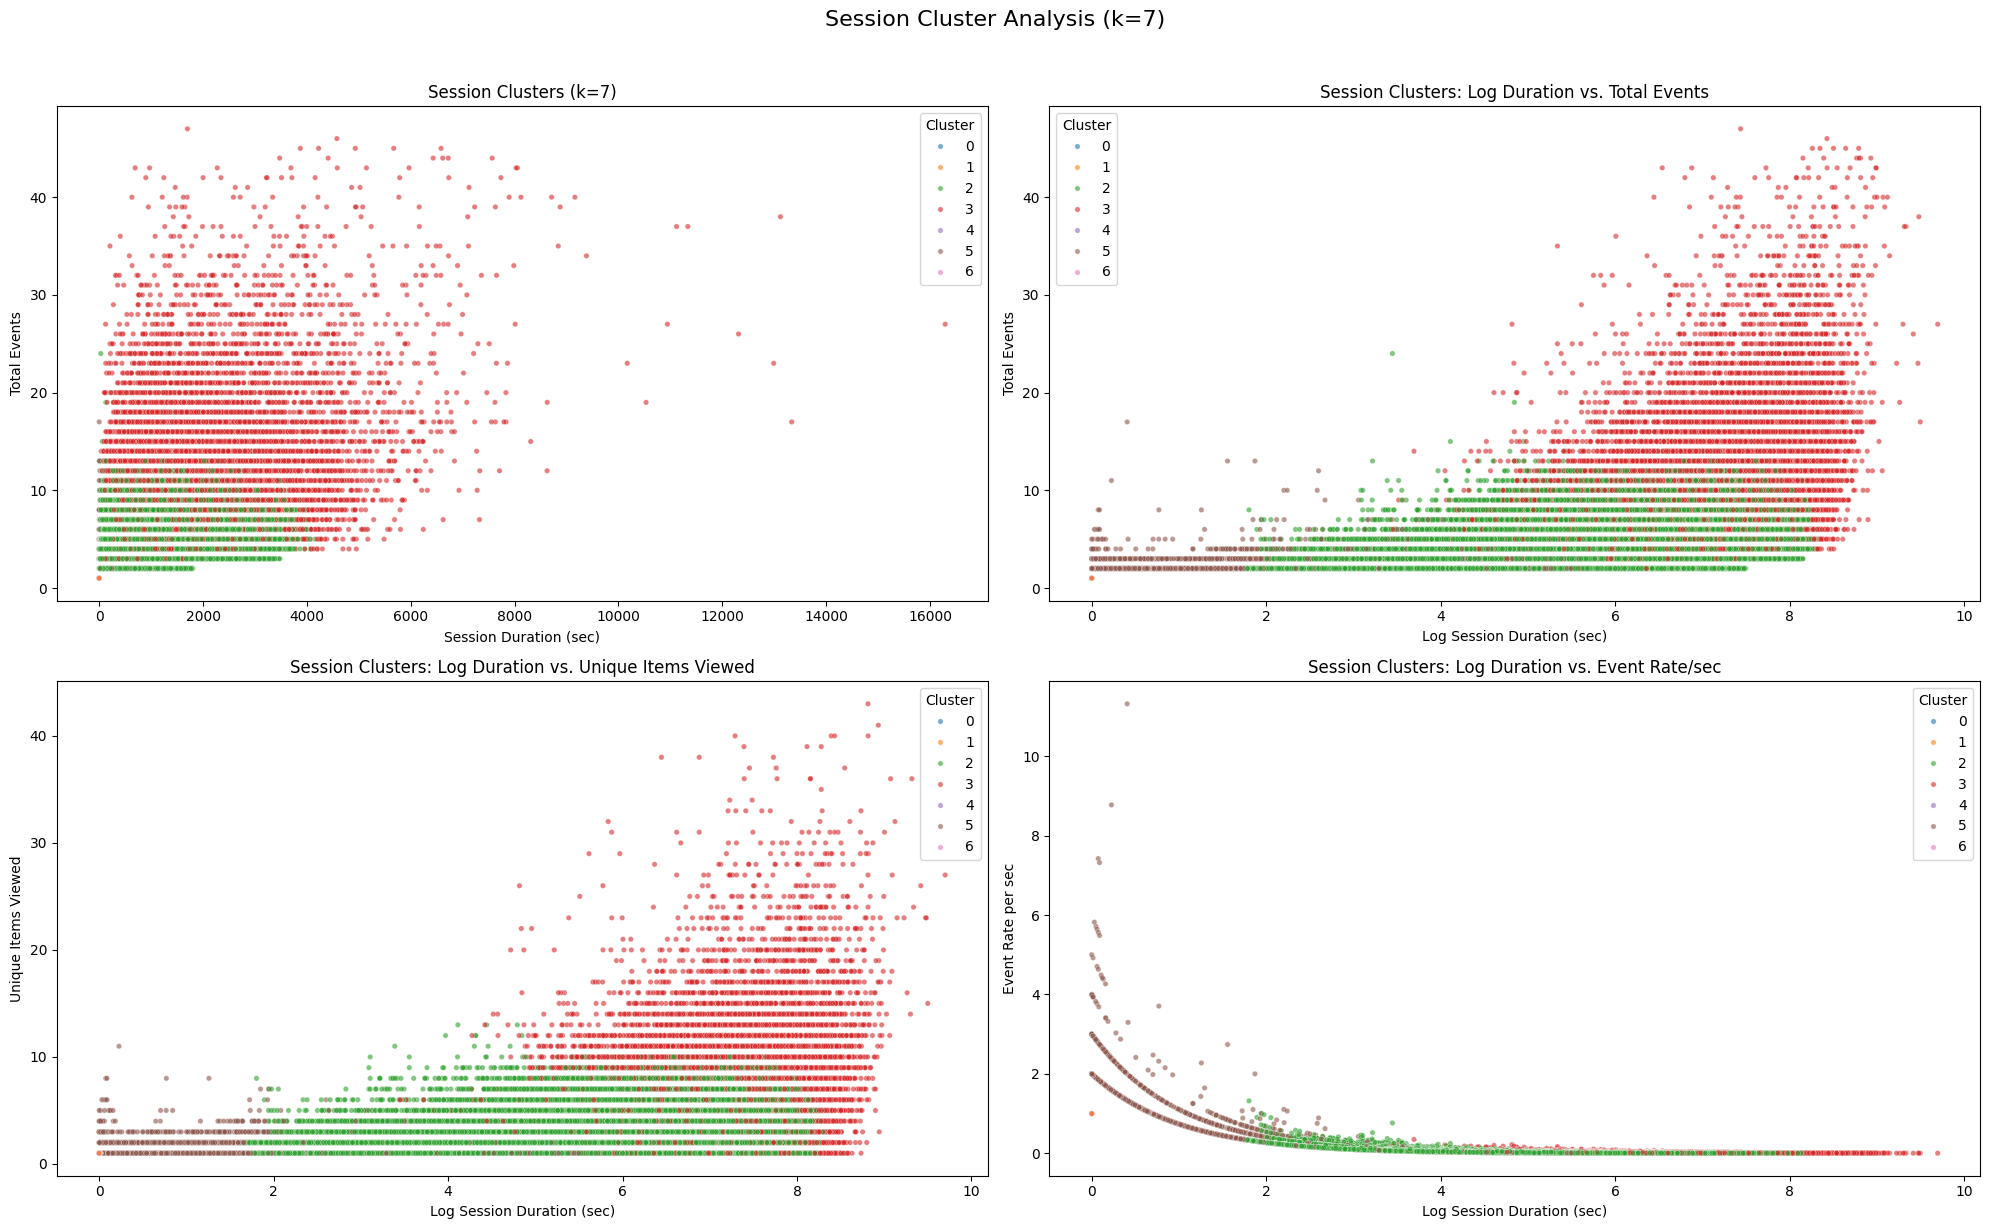

In [14]:
df_gmm_clusters = pd.read_csv(f'{OUTPUTS_DIR}/session_feature_matrix_with_gmm_clusters.csv', index_col='session_id')

# Pre-calculate the log duration column once
df_gmm_clusters['log_session_duration'] = np.log(df_gmm_clusters['session_duration_sec'] + 1)

#  Create the 2x2 Subplot Grid
# Create one figure and a 2x2 grid of axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Add a main title for the entire figure
fig.suptitle('Session Cluster Analysis (k=7)', fontsize=16, y=1.02)


# 1. Session Duration vs. Total Events (linear)
# Plot on the first axis: axes[0, 0]
sns.scatterplot(
    data=df_gmm_clusters,
    x='session_duration_sec',
    y='total_events',
    hue='cluster_gmm',
    palette='tab10',
    alpha=0.6,
    s=15,
    ax=axes[0, 0]  # Directs plot to the top-left subplot
)
axes[0, 0].set_title('Session Clusters (k=7)')
axes[0, 0].set_xlabel('Session Duration (sec)')
axes[0, 0].set_ylabel('Total Events')
axes[0, 0].legend(title='Cluster')


# 2. Log(Session Duration) vs. Total Events
# Plot on the second axis: axes[0, 1]
sns.scatterplot(
    data=df_gmm_clusters,
    x='log_session_duration',
    y='total_events',
    hue='cluster_gmm',
    palette='tab10',
    alpha=0.6,
    s=15,
    ax=axes[0, 1]  # Directs plot to the top-right subplot
)
axes[0, 1].set_title('Session Clusters: Log Duration vs. Total Events')
axes[0, 1].set_xlabel('Log Session Duration (sec)')
axes[0, 1].set_ylabel('Total Events')
axes[0, 1].legend(title='Cluster')


# 3. Log(Session Duration) vs. Unique Items Viewed
# Plot on the third axis: axes[1, 0]
sns.scatterplot(
    data=df_gmm_clusters,
    x='log_session_duration',
    y='unique_items_viewed',
    hue='cluster_gmm',
    palette='tab10',
    alpha=0.6,
    s=15,
    ax=axes[1, 0]  # Directs plot to the bottom-left subplot
)
axes[1, 0].set_title('Session Clusters: Log Duration vs. Unique Items Viewed')
axes[1, 0].set_xlabel('Log Session Duration (sec)')
axes[1, 0].set_ylabel('Unique Items Viewed')
axes[1, 0].legend(title='Cluster')


# 4. Log(Session Duration) vs. Event Rate per Second
# Plot on the fourth axis: axes[1, 1]
sns.scatterplot(
    data=df_gmm_clusters,
    x='log_session_duration',
    y='event_rate_per_sec',
    hue='cluster_gmm',
    palette='tab10',
    alpha=0.6,
    s=15,
    ax=axes[1, 1]  # Directs plot to the bottom-right subplot
)
axes[1, 1].set_title('Session Clusters: Log Duration vs. Event Rate/sec')
axes[1, 1].set_xlabel('Log Session Duration (sec)')
axes[1, 1].set_ylabel('Event Rate per sec')
axes[1, 1].legend(title='Cluster')


#  Finalize and Show Plot
# Apply tight_layout to the whole figure and then show it
plt.tight_layout()
plt.show()

## Association Rule Mining

### Market Basket Analysis

In [15]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r".*utcnow\(\) is deprecated.*"
)

In [19]:
if 'BASE_DIR' not in locals():
  BASE_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project'

try:
    # 1. Load the cluster assignments
    df_clusters = pd.read_csv(f'{OUTPUTS_DIR}/session_feature_matrix_with_gmm_clusters.csv', index_col='session_id')
    print(f"Successfully loaded {len(df_clusters)} sessions with cluster labels.")

    # 2. Load the raw events log
    df_events_raw = pd.read_csv(f'{BASE_DIR}/dataset/events.csv')
    print(f"Successfully loaded {len(df_events_raw)} raw events.")

    # 3. Load the category baskets
    with open(f'{BASE_DIR}/category_baskets.csv', 'r') as f:
        all_baskets_list = [list(map(int, line.strip().split(','))) for line in f]

    # We also need the transactionid index from that file for mapping
    basket_index_df = pd.read_csv(f'{BASE_DIR}/category_baskets.csv', header=None, usecols=[0], names=['transactionid'])

    # --- THIS IS THE FIX ---
    # REASONING: We explicitly create a DataFrame with one column named 'basket'
    # and assign the list of lists (all_baskets_list) to that single column.
    basket_map = pd.DataFrame({'basket': all_baskets_list}, index=basket_index_df['transactionid'])

    print(f"Successfully loaded {len(basket_map)} total market baskets.")

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
    print("Please ensure 'df_user_features_with_clusters.csv', 'events.csv', and 'category_baskets.csv' are in the same directory.")

try:
    print("Re-running cleaning and sessionization to create session-transaction map...")

    # Fill expected NaNs
    df_events_raw['transactionid'] = df_events_raw['transactionid'].fillna(0).astype(int)

    # 2. Re-run identical noise handling from Milestone 1
    events_per_visitor = df_events_raw.groupby('visitorid')['event'].count()
    outlier_threshold = events_per_visitor.quantile(0.999)
    outlier_visitors = events_per_visitor[events_per_visitor > outlier_threshold].index
    df_events_cleaned = df_events_raw[~df_events_raw['visitorid'].isin(outlier_visitors)].copy()

    # 3. Re-run identical sessionization from Milestone 1
    df_events_cleaned['timestamp_dt'] = pd.to_datetime(df_events_cleaned['timestamp'], unit='ms')
    df_events_cleaned.sort_values(by=['visitorid', 'timestamp_dt'], inplace=True)
    session_timeout_seconds = 30 * 60
    df_events_cleaned['time_diff_seconds'] = df_events_cleaned.groupby('visitorid')['timestamp_dt'].diff().dt.total_seconds()
    df_events_cleaned['new_session_flag'] = (df_events_cleaned['time_diff_seconds'] > session_timeout_seconds) | (df_events_cleaned['time_diff_seconds'].isnull())
    df_events_cleaned['session_increment_id'] = df_events_cleaned.groupby('visitorid')['new_session_flag'].cumsum()
    df_events_cleaned['session_id'] = df_events_cleaned['visitorid'].astype(str) + '_' + df_events_cleaned['session_increment_id'].astype(str)

    # 4. Create the final map
    # We only need session_id and transactionid, and we only care about actual transactions
    session_to_transaction_map = df_events_cleaned[
        df_events_cleaned['transactionid'] != 0
    ][['session_id', 'transactionid']].drop_duplicates()

    print(f"Successfully created mapping for {len(session_to_transaction_map)} session-transaction pairs.")
    print(session_to_transaction_map.head())
except FileNotFoundError as e:
    print(f"Error: Failed to create sessionization to create session-transaction map. {e}")
    print("Please ensure 'session_feature_matrix_with_k7_clusters.csv', 'events.csv', and 'category_baskets.csv' are in the same directory.")


Successfully loaded 1722864 sessions with cluster labels.
Successfully loaded 2756101 raw events.
Successfully loaded 12185 total market baskets.
Re-running cleaning and sessionization to create session-transaction map...
Successfully created mapping for 12191 session-transaction pairs.
        session_id  transactionid
848114       172_4           9725
814996       186_1           8726
1276395      264_1           8445
2687635      419_3          16455
273133       539_1          14778


In [20]:
# Identify our target cluster's session IDs
# Combined clusters 3 and 5 - Buyers
# After loading k=7 cluster assignments
merged_cluster_mask = (df_clusters['cluster_gmm'] == 3) | (df_clusters['cluster_gmm'] == 5)
merged_buyer_sessions = df_clusters[merged_cluster_mask].index

buyer_session_ids = merged_buyer_sessions
print(f"Identified {len(buyer_session_ids):,} sessions in Clusters 3 and 5.")

# 2. Find the transaction IDs for this cluster
target_transactions = session_to_transaction_map[
    session_to_transaction_map['session_id'].isin(buyer_session_ids)
]
target_transaction_ids = target_transactions['transactionid'].unique()
print(f"Found {len(target_transaction_ids):,} unique transaction IDs for Clusters 3 and 5.")

# 3. Filter the main basket_map
cluster_baskets_df = basket_map[basket_map.index.isin(target_transaction_ids)]
cluster_baskets_list = cluster_baskets_df['basket'].tolist()

print(f"Successfully filtered to {len(cluster_baskets_list)} market baskets for Apriori.")

Identified 53,343 sessions in Clusters 3 and 5.
Found 12,185 unique transaction IDs for Clusters 3 and 5.
Successfully filtered to 7907 market baskets for Apriori.


In [23]:
# 1. One-hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(cluster_baskets_list).transform(cluster_baskets_list)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# 2. Run Apriori to find frequent itemsets
# We use a higher min_support (0.5%) because this is a larger, sparse group.
frequent_itemsets_cluster = apriori(df_onehot, min_support=0.001, use_colnames=True)
print(f"Found {len(frequent_itemsets_cluster)} frequent itemsets in Cluster 2.")
display(frequent_itemsets_cluster.head())

# 3. Generate association rules
# We filter for a high lift (>= 1.5) to find strong, non-random patterns.
# We filter for a high lift (>= 1.5) to find strong, non-random patterns.
cluster_rules = association_rules(frequent_itemsets_cluster, metric="lift", min_threshold=1.5)
cluster_rules = cluster_rules.sort_values(by='lift', ascending=False)

print(f"Generated {len(cluster_rules)} rules with lift >= 1.5.")

# 4. Display and save results
print("\n# Top 10 Rules for 'Determined Buyers' (by Lift)")
display(cluster_rules.head(10))
cluster_rules.to_csv(f'{BASE_DIR}/cluster_2_Updated_GMM_rules.csv', index=False)
print("\nSaved Cluster 2 rules to '{BASE_DIR}/cluster_2_Updated_GMM_rules.csv.csv'")

Found 246 frequent itemsets in Cluster 2.


,support,itemsets
0,0.012773,(5)
1,0.003668,(29)
2,0.006956,(34)
3,0.001391,(47)
4,0.013153,(48)


Generated 30 rules with lift >= 1.5.

# Top 10 Rules for 'Determined Buyers' (by Lift)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
16,(427),(1220),0.005438,0.003541,0.002024,0.372093,105.076412,1.0,0.002004,1.586953,0.995899,0.290909,0.369862,0.471761
17,(1220),(427),0.003541,0.005438,0.002024,0.571429,105.076412,1.0,0.002004,2.320644,0.994003,0.290909,0.569085,0.471761
8,(196),(317),0.002150,0.006576,0.001138,0.529412,80.501131,1.0,0.001124,2.111025,0.989706,0.150000,0.526296,0.351244
9,(317),(196),0.006576,0.002150,0.001138,0.173077,80.501131,1.0,0.001124,1.206702,0.994116,0.150000,0.171295,0.351244
6,(624),(126),0.010876,0.002150,0.001518,0.139535,64.900137,1.0,0.001494,1.159664,0.995418,0.131868,0.137681,0.422709
7,(126),(624),0.002150,0.010876,0.001518,0.705882,64.900137,1.0,0.001494,3.363020,0.986713,0.131868,0.702648,0.422709
0,(48),(1244),0.013153,0.001644,0.001265,0.096154,58.483728,1.0,0.001243,1.104564,0.996002,0.093458,0.094665,0.432692
1,(1244),(48),0.001644,0.013153,0.001265,0.769231,58.483728,1.0,0.001243,4.276337,0.984520,0.093458,0.766155,0.432692
26,(1037),(1286),0.017200,0.002276,0.001771,0.102941,45.219771,1.0,0.001731,1.112216,0.995000,0.100000,0.100894,0.440359
27,(1286),(1037),0.002276,0.017200,0.001771,0.777778,45.219771,1.0,0.001731,4.422600,0.980117,0.100000,0.773889,0.440359



Saved Cluster 2 rules to '{BASE_DIR}/cluster_2_Updated_GMM_rules.csv.csv'
